In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, PrecisionRecallDisplay, f1_score
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 10)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics =['accuracy', recall_m, precision_m, f1_m] 

In [ ]:
#Funzione per plot metriche del modello
def plot_history(net_history, x_plot): 
    plt.figure(figsize=(16,12))
    
    fig, axs = plt.subplots(2,2)
    axs[0,0].plot(x_plot, net_history.history['loss'])
    axs[0,0].plot(x_plot, net_history.history['val_loss'])
    axs[0,0].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].set_xlabel('Epochs')
    axs[0,0].legend(['Training', 'Validation','Best Epoch'])

    axs[0,1].plot(x_plot, net_history.history['accuracy'])
    axs[0,1].plot(x_plot, net_history.history['val_accuracy'])
    axs[0,1].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[0,1].set_ylabel('Accuracy')
    axs[0,1].set_xlabel('Epochs')
    axs[0,1].legend(['Training', 'Validation', 'Best Epoch'])

    axs[1,0].plot(x_plot, net_history.history['recall_m'])
    axs[1,0].plot(x_plot, net_history.history['val_recall_m'])
    axs[1,0].plot(x_plot, net_history.history['precision_m'])
    axs[1,0].plot(x_plot, net_history.history['val_precision_m'])
    axs[1,0].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].set_xlabel('Epochs')
    axs[1,0].set_ylabel('Precision/Recall')
    axs[1,0].legend(['Training Recall', 'Validation Recall', 'Training Precision', 
                     'Validation Precision', 'Best Epoch'], loc='upper left')
    
    axs[1,1].plot(x_plot, net_history.history['f1_m'])
    axs[1,1].plot(x_plot, net_history.history['val_f1_m'])
    axs[1,1].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[1,1].set_ylabel('F1')
    axs[1,1].set_xlabel('Epochs')
    axs[1,1].legend(['Training', 'Validation', 'Best Epoch'])
    
    plt.tight_layout()

In [ ]:
data = pd.read_csv('weatherAUS.csv')
data.shape

(145460, 23)

# Metodo 1: Rimozione di tutte le rige con missing data

## Preprocessing

Rimozione NaN

In [ ]:
df = data[~data.isnull().any(axis=1)]
df.reset_index(drop=True, inplace=True)
df.shape

(56420, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].map(dict(Yes=1, No=0))

In [ ]:
num_var = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
           'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 
           'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
cat_var = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [ ]:
#Creazione dataset di training, validation e test
xtrain, xtest, ytrain, ytest = train_test_split (df.drop("RainTomorrow", axis=1), 
                                                 df["RainTomorrow"], random_state=42, test_size=0.10, 
                                                 stratify=df["RainTomorrow"])

xtrain, xval, ytrain, yval = train_test_split (xtrain, ytrain, random_state=42, test_size=0.1, stratify=ytrain)

In [ ]:
print(xtrain.shape, xval.shape, xtest.shape)

(45700, 22) (5078, 22) (5642, 22)


## Correlazione

Le variabili correlate sono riferite al medesimo attributo. Vengono mantenute perchè la rete neurale gestisce la questione internamente

<AxesSubplot:>

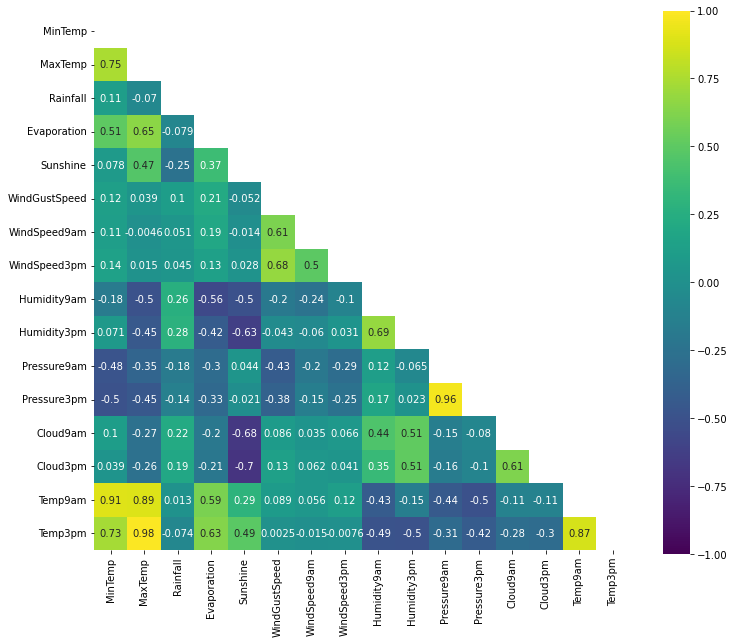

In [ ]:
corrMatrix = xtrain[num_var].corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))

sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, vmax=1, vmin=-1, cmap='viridis')

## Standardizzazione

In [ ]:
scaler = StandardScaler()
scaler.fit(xtrain[num_var])
xtrain_num = pd.DataFrame(scaler.transform(xtrain[num_var]), columns=xtrain[num_var].columns, index = xtrain.index)

In [ ]:
#applicata al validation
xval_num = pd.DataFrame(scaler.transform(xval[num_var]), columns=xval[num_var].columns, index = xval.index)
#applicata al test
xtest_num = pd.DataFrame(scaler.transform(xtest[num_var]), columns=xtest[num_var].columns, index = xtest.index)

## One-Hot Encoding

In [ ]:
enc = OneHotEncoder()
enc.fit(xtrain[cat_var])
xtrain_cat = pd.DataFrame(enc.transform(xtrain[cat_var]).toarray(), 
                          columns=enc.get_feature_names_out(), index = xtrain.index)

In [ ]:
# Applicata al validation
xval_cat = pd.DataFrame(enc.transform(xval[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xval.index)
# Applicata al test
xtest_cat = pd.DataFrame(enc.transform(xtest[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xtest.index)

Le variabili vengono congiunte in un dato unico

In [ ]:
Xtrain = pd.merge(xtrain_num, xtrain_cat, left_index=True, right_index=True)
Xval = pd.merge(xval_num, xval_cat, left_index=True, right_index=True)
Xtest = pd.merge(xtest_num, xtest_cat, left_index=True, right_index=True)

## Undersampling

In [ ]:
# Undersampling
us = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
xtrain_res, ytrain_res = us.fit_resample(Xtrain, ytrain)

In [ ]:
print(ytrain.value_counts())
print(ytrain_res.value_counts())

0    35634
1    10066
Name: RainTomorrow, dtype: int64
0    14380
1    10066
Name: RainTomorrow, dtype: int64


In [ ]:
# Proporzione
print(ytrain.value_counts()/len(ytrain))
print(ytrain_res.value_counts()/len(ytrain_res))

0    0.779737
1    0.220263
Name: RainTomorrow, dtype: float64
0    0.588235
1    0.411765
Name: RainTomorrow, dtype: float64


## Model Hyperparameter Tuning

Viene utilizzato Keras Tuner per l'ottimizzazione degli iperparametri

In [ ]:
xtrain_res.shape

(24446, 92)

In [ ]:
#L'ottimizzazione relativa al numero di neuroni cercando di mantenere il numero
# decrescente dall'input all'output
initializer = tf.keras.initializers.GlorotUniform(seed=42)

def model_builder_dropout(hp):
    model = Sequential()
    
    #Input con neuroni variabili tra 64 e 128 e Dropout tra 0.1 e 0.7
    model.add(Dense(units  = hp.Choice('input', values=[64, 128]), input_shape=(92,), 
                    activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.7, step=0.1)))

    #Primo hidden layer con neuroni variabili tra 32 e 64 e Dropout tra 0.1 e 0.7
    model.add(Dense(units=hp.Choice('hidden_1', values=[32, 64]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_1', min_value=0.1, max_value=0.7, step=0.1)))

    #Secondo hidden layer con neuroni variabili tra 16 e 32 e Dropout tra 0.1 e 0.7
    model.add(Dense(units=hp.Choice('hidden_2', values=[16, 32]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [ ]:
#Tuner con F1-score del validation set come funzione obiettivo, ottimizzando
# i parametri per 3 iterazioni di Hyperband
tuner = kt.Hyperband(model_builder_dropout,
                     objective=kt.Objective("val_f1_m", direction="max"),
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=3,
                     directory='my_dir_new',
                     project_name='modelnomissing')

In [ ]:
stop_early = EarlyStopping(monitor='val_f1_m', patience=5)

In [ ]:
tuner.search(xtrain_res, ytrain_res, epochs=50, validation_data=(Xval, yval), callbacks=[stop_early])

Trial 90 Complete [00h 00m 11s]
val_f1_m: 0.6247072815895081

Best val_f1_m So Far: 0.632371723651886
Total elapsed time: 00h 10m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Modelli migliori
tuner.results_summary()

Results summary
Results in my_dir_new\modelnomissing
Showing 10 best trials
Objective(name='val_f1_m', direction='max')
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.2
hidden_1: 64
dropout_1: 0.1
hidden_2: 16
dropout_2: 0.1
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.632371723651886
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.2
hidden_1: 64
dropout_1: 0.1
hidden_2: 16
dropout_2: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 075ffe3615d4a57f6d9afce9237aa809
Score: 0.6292649507522583
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.1
hidden_1: 32
dropout_1: 0.2
hidden_2: 32
dropout_2: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 5e42f636a806cffde569d4d8fa5099a3
Score: 0.6290698647499084
Trial summary
Hyperparameters:
input: 64
dropout_input: 0.2
hidden_1: 64
dropout_1: 0.5
hidden_2: 16
dropout_2: 0.2
tuner/epochs: 10
tuner/

In [ ]:
# Iperparametri ottimali
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# modello con iperparametri ottimali
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               11904     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
#allenamento del modello con gli iperparametri ottimizzati
n_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta = 0.001, verbose=1, restore_best_weights=True) 

history = model.fit(xtrain_res, ytrain_res, epochs=n_epochs, batch_size=32, 
                    verbose=2, validation_data=(Xval, yval),callbacks=[early_stop])

Epoch 1/100
764/764 - 2s - loss: 0.5510 - accuracy: 0.6936 - recall_m: 0.3591 - precision_m: 0.5901 - f1_m: 0.4142 - val_loss: 0.4121 - val_accuracy: 0.7891 - val_recall_m: 0.7582 - val_precision_m: 0.5173 - val_f1_m: 0.5972 - 2s/epoch - 3ms/step
Epoch 2/100
764/764 - 1s - loss: 0.4658 - accuracy: 0.7897 - recall_m: 0.7686 - precision_m: 0.7350 - f1_m: 0.7442 - val_loss: 0.4003 - val_accuracy: 0.7944 - val_recall_m: 0.7872 - val_precision_m: 0.5262 - val_f1_m: 0.6115 - 1s/epoch - 2ms/step
Epoch 3/100
764/764 - 1s - loss: 0.4418 - accuracy: 0.7962 - recall_m: 0.7677 - precision_m: 0.7471 - f1_m: 0.7501 - val_loss: 0.4031 - val_accuracy: 0.8001 - val_recall_m: 0.8003 - val_precision_m: 0.5357 - val_f1_m: 0.6220 - 1s/epoch - 2ms/step
Epoch 4/100
764/764 - 1s - loss: 0.4300 - accuracy: 0.8013 - recall_m: 0.7748 - precision_m: 0.7497 - f1_m: 0.7547 - val_loss: 0.3854 - val_accuracy: 0.8086 - val_recall_m: 0.7647 - val_precision_m: 0.5487 - val_f1_m: 0.6214 - 1s/epoch - 2ms/step
Epoch 5/100


Epoch 35/100
764/764 - 1s - loss: 0.3587 - accuracy: 0.8387 - recall_m: 0.8051 - precision_m: 0.8055 - f1_m: 0.7986 - val_loss: 0.3692 - val_accuracy: 0.8234 - val_recall_m: 0.7812 - val_precision_m: 0.5805 - val_f1_m: 0.6473 - 1s/epoch - 2ms/step
Epoch 36/100
764/764 - 1s - loss: 0.3559 - accuracy: 0.8374 - recall_m: 0.8070 - precision_m: 0.7975 - f1_m: 0.7963 - val_loss: 0.3674 - val_accuracy: 0.8234 - val_recall_m: 0.7763 - val_precision_m: 0.5803 - val_f1_m: 0.6448 - 1s/epoch - 2ms/step
Epoch 37/100
764/764 - 1s - loss: 0.3567 - accuracy: 0.8397 - recall_m: 0.8022 - precision_m: 0.8061 - f1_m: 0.7978 - val_loss: 0.3700 - val_accuracy: 0.8210 - val_recall_m: 0.7838 - val_precision_m: 0.5758 - val_f1_m: 0.6450 - 1s/epoch - 2ms/step
Epoch 38/100
764/764 - 1s - loss: 0.3560 - accuracy: 0.8387 - recall_m: 0.8067 - precision_m: 0.8044 - f1_m: 0.7988 - val_loss: 0.3696 - val_accuracy: 0.8224 - val_recall_m: 0.7788 - val_precision_m: 0.5775 - val_f1_m: 0.6447 - 1s/epoch - 2ms/step
Epoch 39

## Risultati

<Figure size 1152x864 with 0 Axes>

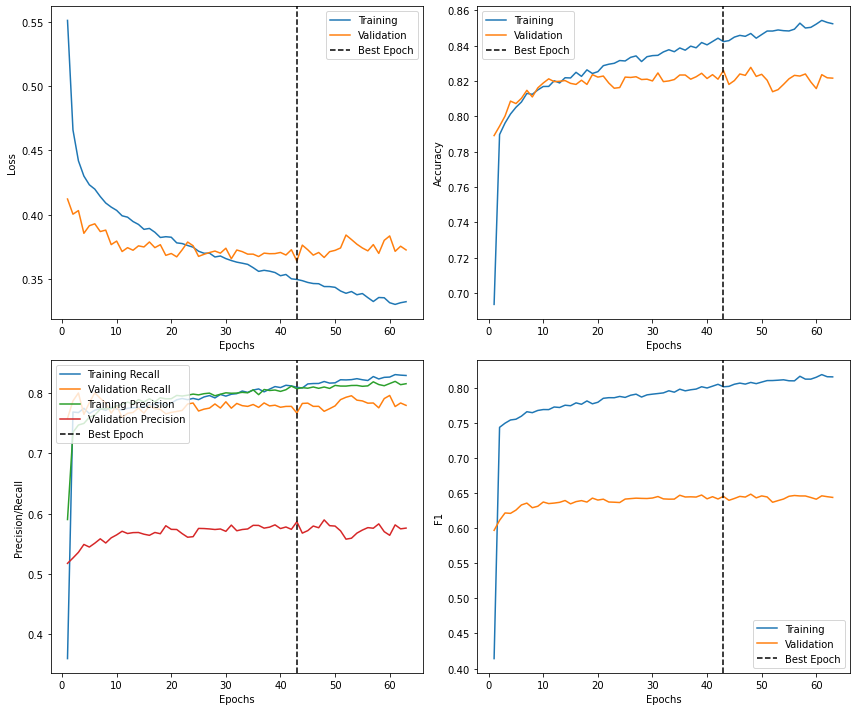

In [ ]:
try:
    x_plot = list(range(1,early_stop.best_epoch+early_stop.patience+2))
except:
    x_plot = list(range(1,n_epochs+1))
plot_history(history, x_plot)

In [ ]:
print('Classification Report')
predictions = model.predict(Xtest)
y_classes = (predictions > 0.5).astype(np.int8)
print(classification_report(ytest,y_classes))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes)
print(cm)
print('*****************************')
AUC_m1 = roc_auc_score(ytest, y_classes)
print('AUC: {}'.format(AUC_m1))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      4399
           1       0.60      0.79      0.68      1243

    accuracy                           0.84      5642
   macro avg       0.77      0.82      0.79      5642
weighted avg       0.86      0.84      0.84      5642

*****************************
Confusion Matrix
[[3748  651]
 [ 265  978]]
*****************************
AUC: 0.8194089675540608


In [ ]:
#Ricerca del valore di threshold con F1 più elevato
f1_scores = []
for i in np.arange(0,1,0.01):
    y_classes_thresh = (predictions > i).astype(np.int8)
    f1_scores.append(f1_score(ytest, y_classes_thresh))
f1_scores = np.array(f1_scores)
print('Best Threshold: {}'.format(np.argmax(f1_scores)*0.01))

Best Threshold: 0.61


In [ ]:
#Metriche con threshold ottimale
print('Classification Report')
y_classes_best_thresh = (predictions > (np.argmax(f1_scores)*0.01)).astype(np.int8)
print(classification_report(ytest, y_classes_best_thresh))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes_best_thresh)
print(cm)
print('*****************************')
AUC_m1_thresh = roc_auc_score(ytest, y_classes_best_thresh)
print('AUC: {}'.format(AUC_m1_thresh))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4399
           1       0.67      0.71      0.69      1243

    accuracy                           0.86      5642
   macro avg       0.79      0.80      0.80      5642
weighted avg       0.86      0.86      0.86      5642

*****************************
Confusion Matrix
[[3965  434]
 [ 363  880]]
*****************************
AUC: 0.8046529078410821


ROC Curve

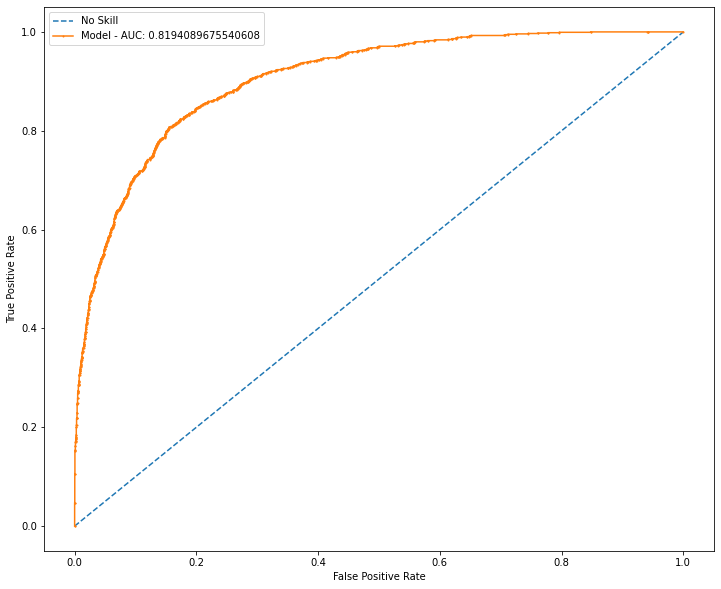

In [ ]:
fpr_m1_opt, tpr_m1_opt, thresholds_m1_opt = roc_curve(ytest, predictions)
ns_probs_m1_opt = [0 for _ in range(len(ytest))]
fpr2_m1_opt, tpr2_m1_opt, thresholds_m1_opt = roc_curve(ytest, ns_probs_m1_opt)


plt.plot(fpr2_m1_opt, tpr2_m1_opt, linestyle='--', label='No Skill')
plt.plot(fpr_m1_opt, tpr_m1_opt, marker='.',markersize=2, label='Model - AUC: {}'.format(AUC_m1))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Precision-Recall Curve

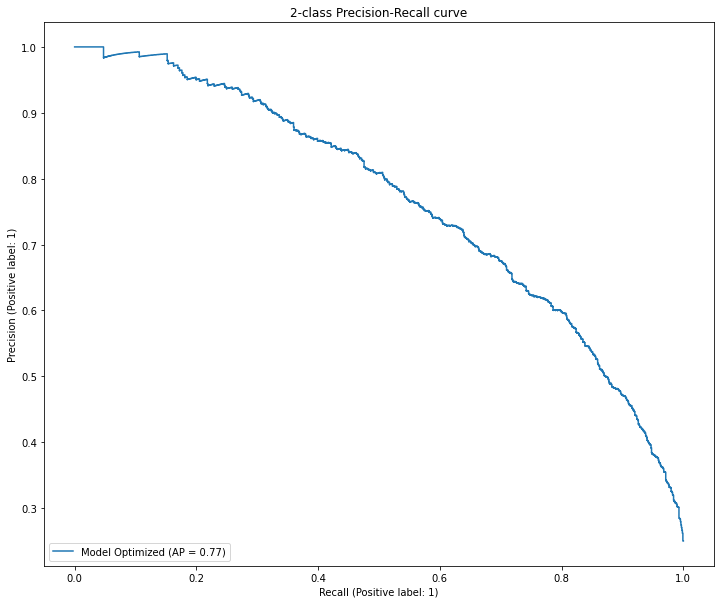

In [ ]:
display_m1_opt = PrecisionRecallDisplay.from_predictions(ytest, predictions, name="Model Optimized")
_ = display_m1_opt.ax_.set_title("2-class Precision-Recall curve")

# Metodo 2: Rimozione delle colonne con più missing --> Rimozione delle righe con almeno un missing

## Preprocessing

Rimozione NaN

In [ ]:
df = data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1).dropna()
df.reset_index(inplace=True, drop=True)

df.shape

(112925, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112925 entries, 0 to 112924
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           112925 non-null  object 
 1   Location       112925 non-null  object 
 2   MinTemp        112925 non-null  float64
 3   MaxTemp        112925 non-null  float64
 4   Rainfall       112925 non-null  float64
 5   WindGustDir    112925 non-null  object 
 6   WindGustSpeed  112925 non-null  float64
 7   WindDir9am     112925 non-null  object 
 8   WindDir3pm     112925 non-null  object 
 9   WindSpeed9am   112925 non-null  float64
 10  WindSpeed3pm   112925 non-null  float64
 11  Humidity9am    112925 non-null  float64
 12  Humidity3pm    112925 non-null  float64
 13  Pressure9am    112925 non-null  float64
 14  Pressure3pm    112925 non-null  float64
 15  Temp9am        112925 non-null  float64
 16  Temp3pm        112925 non-null  float64
 17  RainToday      112925 non-nul

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].map(dict(Yes=1, No=0))

In [ ]:
num_var = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
                'WindSpeed3pm',	'Humidity9am',	'Humidity3pm',	'Pressure9am',	'Pressure3pm',	
                'Temp9am',	'Temp3pm']
cat_var = ['Location',	'WindGustDir',	'WindDir9am',	'WindDir3pm',	'RainToday']

## Splitting

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split (df.drop("RainTomorrow", axis=1), df["RainTomorrow"], 
                                                 random_state=42, test_size=0.1, stratify=df["RainTomorrow"])

In [ ]:
xtrain, xval, ytrain, yval = train_test_split (xtrain, ytrain, random_state=42, test_size=0.1, stratify=ytrain)

In [ ]:
print(xtrain.shape, xval.shape, xtest.shape)

(91468, 18) (10164, 18) (11293, 18)


## Correlazione

<AxesSubplot:>

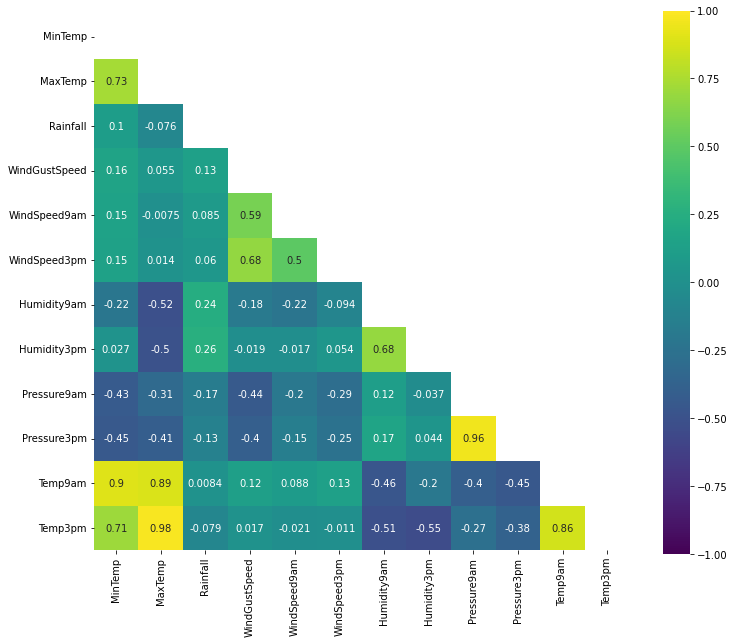

In [ ]:
corrMatrix = xtrain[num_var].corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))

sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, vmax=1, vmin=-1, cmap='viridis')

## Standardizzazione

In [ ]:
scaler = StandardScaler()
scaler.fit(xtrain[num_var])
xtrain_num = pd.DataFrame(scaler.transform(xtrain[num_var]), columns=xtrain[num_var].columns, index = xtrain.index)

In [ ]:
#applicata al validation
xval_num = pd.DataFrame(scaler.transform(xval[num_var]), columns=xval[num_var].columns, index = xval.index)
#applicata al test
xtest_num = pd.DataFrame(scaler.transform(xtest[num_var]), columns=xtest[num_var].columns, index = xtest.index)

## One-Hot Encoding

In [ ]:
enc = OneHotEncoder()
enc.fit(xtrain[cat_var])
xtrain_cat = pd.DataFrame(enc.transform(xtrain[cat_var]).toarray(), 
                          columns=enc.get_feature_names_out(), index = xtrain.index)

In [ ]:
# Applicata al validation
xval_cat = pd.DataFrame(enc.transform(xval[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xval.index)
# Applicata al test
xtest_cat = pd.DataFrame(enc.transform(xtest[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xtest.index)

In [ ]:
Xtrain = pd.merge(xtrain_num, xtrain_cat, left_index=True, right_index=True)
Xval = pd.merge(xval_num, xval_cat, left_index=True, right_index=True)
Xtest = pd.merge(xtest_num, xtest_cat, left_index=True, right_index=True)

## Undersampling

In [ ]:
# Undersampling
us = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
xtrain_res, ytrain_res = us.fit_resample(Xtrain, ytrain)

In [ ]:
print(ytrain.value_counts())
print(ytrain_res.value_counts())

0    71203
1    20265
Name: RainTomorrow, dtype: int64
0    28950
1    20265
Name: RainTomorrow, dtype: int64


In [ ]:
# Proporzione
print(ytrain.value_counts()/len(ytrain))
print(ytrain_res.value_counts()/len(ytrain_res))

0    0.778447
1    0.221553
Name: RainTomorrow, dtype: float64
0    0.588235
1    0.411765
Name: RainTomorrow, dtype: float64


## Model Hyperparameter Tuning

In [ ]:
xtrain_res.shape

(49215, 106)

In [ ]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)

def model_builder_dropout(hp):
    model = Sequential()
    
    model.add(Dense(units  = hp.Choice('input', values=[64, 128]), input_shape=(106,), 
                    activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=hp.Choice('hidden_1', values=[32, 64]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_1', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=hp.Choice('hidden_2', values=[16, 32]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [ ]:
tuner = kt.Hyperband(model_builder_dropout,
                     objective=kt.Objective("val_f1_m", direction="max"),
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=3,
                     directory='my_dir_new',
                     project_name='modelcolumndrop')

In [ ]:
stop_early = EarlyStopping(monitor='val_f1_m', patience=5)

In [ ]:
tuner.search(xtrain_res, ytrain_res, epochs=50, validation_data=(Xval, yval), callbacks=[stop_early])

Trial 90 Complete [00h 00m 22s]
val_f1_m: 0.6316854357719421

Best val_f1_m So Far: 0.6518798470497131
Total elapsed time: 00h 18m 56s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir_new\modelcolumndrop
Showing 10 best trials
Objective(name='val_f1_m', direction='max')
Trial summary
Hyperparameters:
input: 64
dropout_input: 0.1
hidden_1: 64
dropout_1: 0.30000000000000004
hidden_2: 32
dropout_2: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 32cdddac776915a7239a20307d9b1810
Score: 0.6518798470497131
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.2
hidden_1: 64
dropout_1: 0.4
hidden_2: 16
dropout_2: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 335ec4ef3d88e6e1c9671a283f2f85d5
Score: 0.6514245867729187
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.2
hidden_1: 64
dropout_1: 0.30000000000000004
hidden_2: 32
dropout_2: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6483997106552124
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.5
hidden_1: 64
dropout_1: 0.1
hidden_2: 32
dro

In [ ]:
# Iperparametri ottimali
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# modello con iperparametri ottimali
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                6848      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta = 0.001, verbose=1, restore_best_weights=True) 

history = model.fit(xtrain_res, ytrain_res, epochs=n_epochs, batch_size=32, 
                    verbose=2, validation_data=(Xval, yval),callbacks=[early_stop])

Epoch 1/100
1538/1538 - 3s - loss: 0.5354 - accuracy: 0.7355 - recall_m: 0.5665 - precision_m: 0.7134 - f1_m: 0.5987 - val_loss: 0.4132 - val_accuracy: 0.8032 - val_recall_m: 0.7339 - val_precision_m: 0.5445 - val_f1_m: 0.6101 - 3s/epoch - 2ms/step
Epoch 2/100
1538/1538 - 2s - loss: 0.4649 - accuracy: 0.7840 - recall_m: 0.7213 - precision_m: 0.7465 - f1_m: 0.7256 - val_loss: 0.4000 - val_accuracy: 0.8108 - val_recall_m: 0.7563 - val_precision_m: 0.5583 - val_f1_m: 0.6268 - 2s/epoch - 2ms/step
Epoch 3/100
1538/1538 - 2s - loss: 0.4504 - accuracy: 0.7932 - recall_m: 0.7281 - precision_m: 0.7592 - f1_m: 0.7358 - val_loss: 0.3835 - val_accuracy: 0.8219 - val_recall_m: 0.7521 - val_precision_m: 0.5793 - val_f1_m: 0.6382 - 2s/epoch - 2ms/step
Epoch 4/100
1538/1538 - 2s - loss: 0.4414 - accuracy: 0.7977 - recall_m: 0.7296 - precision_m: 0.7684 - f1_m: 0.7406 - val_loss: 0.3828 - val_accuracy: 0.8241 - val_recall_m: 0.7551 - val_precision_m: 0.5823 - val_f1_m: 0.6418 - 2s/epoch - 2ms/step
Epoc

Epoch 34/100
1538/1538 - 2s - loss: 0.3789 - accuracy: 0.8276 - recall_m: 0.7753 - precision_m: 0.7994 - f1_m: 0.7802 - val_loss: 0.3509 - val_accuracy: 0.8438 - val_recall_m: 0.7748 - val_precision_m: 0.6219 - val_f1_m: 0.6752 - 2s/epoch - 2ms/step
Epoch 35/100
1538/1538 - 3s - loss: 0.3782 - accuracy: 0.8302 - recall_m: 0.7750 - precision_m: 0.8052 - f1_m: 0.7830 - val_loss: 0.3439 - val_accuracy: 0.8459 - val_recall_m: 0.7654 - val_precision_m: 0.6306 - val_f1_m: 0.6758 - 3s/epoch - 2ms/step
Epoch 36/100
1538/1538 - 2s - loss: 0.3783 - accuracy: 0.8304 - recall_m: 0.7789 - precision_m: 0.8043 - f1_m: 0.7845 - val_loss: 0.3453 - val_accuracy: 0.8466 - val_recall_m: 0.7659 - val_precision_m: 0.6296 - val_f1_m: 0.6763 - 2s/epoch - 2ms/step
Epoch 37/100
1538/1538 - 2s - loss: 0.3767 - accuracy: 0.8309 - recall_m: 0.7769 - precision_m: 0.8051 - f1_m: 0.7836 - val_loss: 0.3484 - val_accuracy: 0.8429 - val_recall_m: 0.7727 - val_precision_m: 0.6197 - val_f1_m: 0.6729 - 2s/epoch - 2ms/step


## Risultati

<Figure size 1152x864 with 0 Axes>

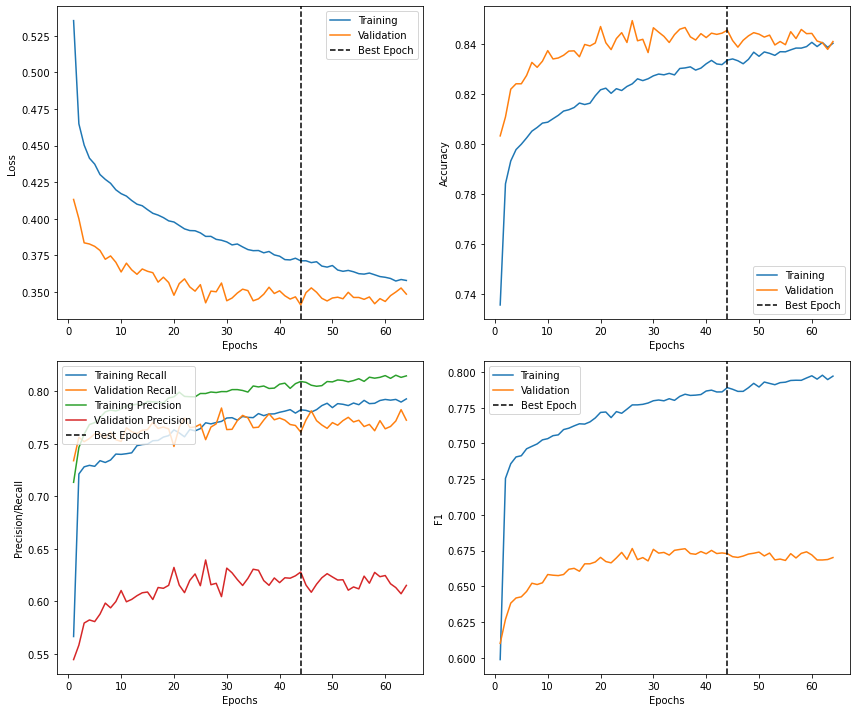

In [ ]:
try:
    x_plot = list(range(1,early_stop.best_epoch+early_stop.patience+2))
except:
    x_plot = list(range(1,n_epochs+1))
plot_history(history, x_plot)

In [ ]:
print('Classification Report')
predictions = model.predict(Xtest)
y_classes = (predictions > 0.5).astype(np.int8)
print(classification_report(ytest,y_classes))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes)
print(cm)
print('*****************************')
AUC_m2 = roc_auc_score(ytest, y_classes)
print('AUC: {}'.format(AUC_m2))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      8791
           1       0.62      0.76      0.68      2502

    accuracy                           0.84     11293
   macro avg       0.77      0.81      0.79     11293
weighted avg       0.86      0.84      0.85     11293

*****************************
Confusion Matrix
[[7621 1170]
 [ 600 1902]]
*****************************
AUC: 0.8135505928097928


In [ ]:
f1_scores = []
for i in np.arange(0,1,0.01):
    y_classes_thresh = (predictions > i).astype(np.int8)
    f1_scores.append(f1_score(ytest, y_classes_thresh))
f1_scores = np.array(f1_scores)
print('Best Threshold: {}'.format(np.argmax(f1_scores)*0.01))

Best Threshold: 0.59


In [ ]:
print('Classification Report')
y_classes_best_thresh = (predictions > (np.argmax(f1_scores)*0.01)).astype(np.int8)
print(classification_report(ytest, y_classes_best_thresh))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes_best_thresh)
print(cm)
print('*****************************')
AUC_m2_thresh = roc_auc_score(ytest, y_classes_best_thresh)
print('AUC: {}'.format(AUC_m2_thresh))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      8791
           1       0.67      0.70      0.69      2502

    accuracy                           0.86     11293
   macro avg       0.79      0.80      0.80     11293
weighted avg       0.86      0.86      0.86     11293

*****************************
Confusion Matrix
[[7945  846]
 [ 745 1757]]
*****************************
AUC: 0.8030017119281483


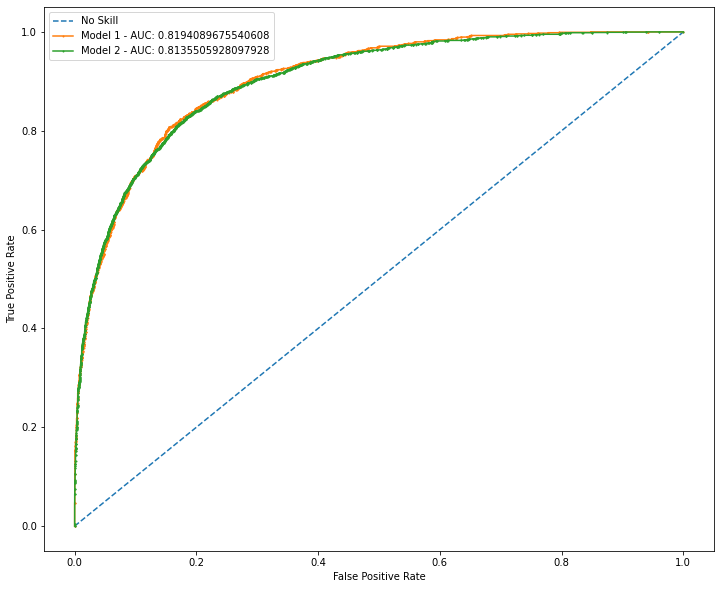

In [ ]:
fpr_m2_opt, tpr_m2_opt, thresholds_m2_opt = roc_curve(ytest, predictions)
ns_probs_m2_opt = [0 for _ in range(len(ytest))]
fpr2_m2_opt, tpr2_m2_opt, thresholds_m2_opt = roc_curve(ytest, ns_probs_m2_opt)


plt.plot(fpr2_m2_opt, tpr2_m2_opt, linestyle='--', label='No Skill')
plt.plot(fpr_m1_opt, tpr_m1_opt, marker='.',markersize=2, label='Model 1 - AUC: {}'.format(AUC_m1))
plt.plot(fpr_m2_opt, tpr_m2_opt, marker='.',markersize=2, label='Model 2 - AUC: {}'.format(AUC_m2))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

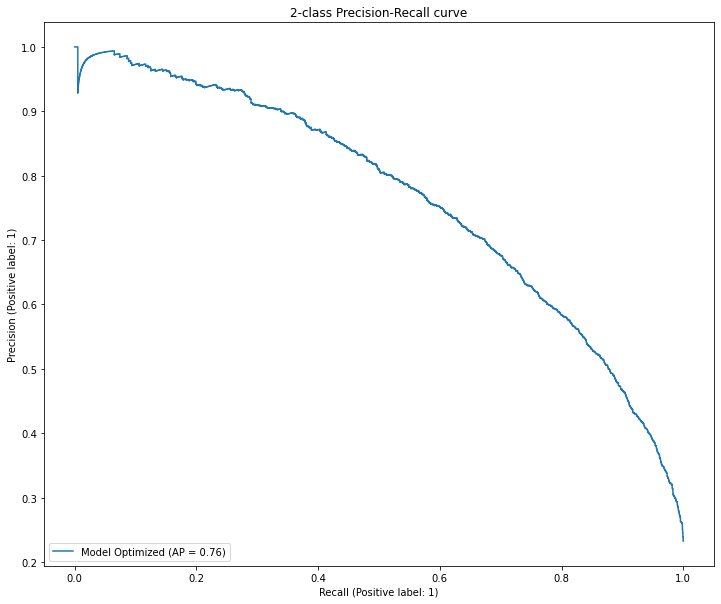

In [ ]:
display_m2_opt = PrecisionRecallDisplay.from_predictions(ytest, predictions, name="Model Optimized")
_ = display_m2_opt.ax_.set_title("2-class Precision-Recall curve")

# Modello 3: Rimozione specifica e Imputazione dei missing

### Dati puliti ed imputati su altro notebook

In [ ]:
xtrain_et = pd.read_csv('weatherAUS_train_shuffled.csv')
xtest_et = pd.read_csv('weatherAUS_test_shuffled.csv')
xval_et = pd.read_csv('weatherAUS_val_shuffled.csv')

In [ ]:
print(xtrain_et.shape,xval_et.shape ,xtest_et.shape)

(61011, 23) (6780, 23) (7533, 23)


In [ ]:
num_var = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed', 'WindSpeed9am',
                'WindSpeed3pm',	'Humidity9am',	'Humidity3pm',	'Pressure9am',	'Pressure3pm',	'Cloud9am',	'Cloud3pm',
                'Temp9am',	'Temp3pm']
cat_var = ['Location',	'WindGustDir',	'WindDir9am',	'WindDir3pm',	'RainToday']

## Correlazione

<AxesSubplot:>

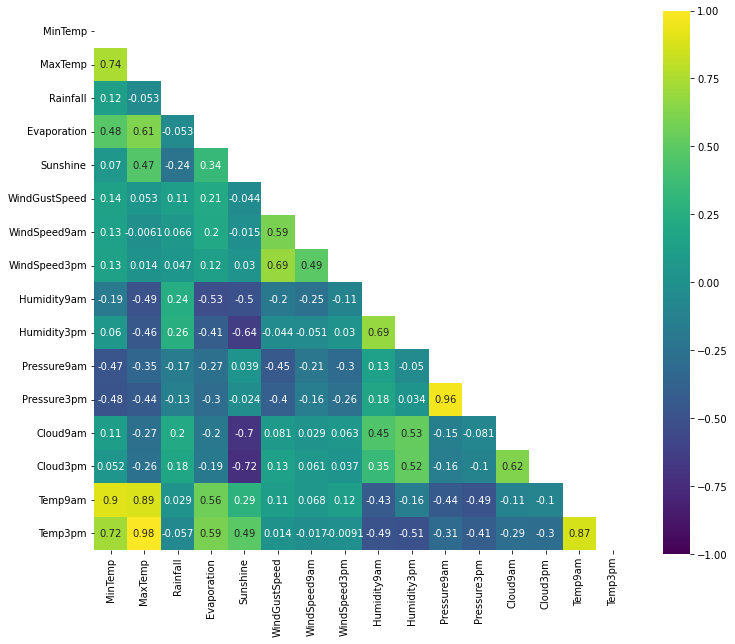

In [ ]:
corrMatrix = xtrain_et[num_var].corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))

sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, vmax=1, vmin=-1, cmap='viridis')

## Standardizzazione

In [ ]:
scaler = StandardScaler()
scaler.fit(xtrain_et[num_var])
xtrain_num = pd.DataFrame(scaler.transform(xtrain_et[num_var]), columns=xtrain_et[num_var].columns, index = xtrain_et.index)

In [ ]:
#applicata al validation
xval_num = pd.DataFrame(scaler.transform(xval_et[num_var]), columns=xval_et[num_var].columns, index = xval_et.index)
#applicata al test
xtest_num = pd.DataFrame(scaler.transform(xtest_et[num_var]), columns=xtest_et[num_var].columns, index = xtest_et.index)

## One-Hot Encoding

In [ ]:
enc = OneHotEncoder()
enc.fit(xtrain_et[cat_var])
xtrain_cat = pd.DataFrame(enc.transform(xtrain_et[cat_var]).toarray(), 
                          columns=enc.get_feature_names_out(), index = xtrain_et.index)

In [ ]:
# Applicata al validation
xval_cat = pd.DataFrame(enc.transform(xval_et[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xval_et.index)
# Applicata al test
xtest_cat = pd.DataFrame(enc.transform(xtest_et[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xtest_et.index)

In [ ]:
Xtrain = pd.merge(xtrain_num, xtrain_cat, left_index=True, right_index=True)
Xval = pd.merge(xval_num, xval_cat, left_index=True, right_index=True)
Xtest = pd.merge(xtest_num, xtest_cat, left_index=True, right_index=True)

In [ ]:
xtrain_et['RainTomorrow'] = xtrain_et['RainTomorrow'].map(dict(Yes=1, No=0))
xval_et['RainTomorrow'] = xval_et['RainTomorrow'].map(dict(Yes=1, No=0))
ytrain = xtrain_et['RainTomorrow']
yval = xval_et['RainTomorrow']

In [ ]:
xtest_et['RainTomorrow'] = xtest_et['RainTomorrow'].map(dict(Yes=1, No=0))
ytest = xtest_et['RainTomorrow']

## Undersampling

In [ ]:
# Undersampling
us = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
xtrain_res, ytrain_res = us.fit_resample(Xtrain, ytrain)

In [ ]:
print(ytrain.value_counts())
print(ytrain_res.value_counts())

0    47890
1    13121
Name: RainTomorrow, dtype: int64
0    18744
1    13121
Name: RainTomorrow, dtype: int64


In [ ]:
# Proporzione
print(ytrain.value_counts()/len(ytrain))
print(ytrain_res.value_counts()/len(ytrain_res))

0    0.78494
1    0.21506
Name: RainTomorrow, dtype: float64
0    0.588232
1    0.411768
Name: RainTomorrow, dtype: float64


## Model Hyperparameter Tuning

In [ ]:
xtrain_res.shape

(31865, 88)

In [ ]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)

def model_builder_dropout(hp):
    model = Sequential()
    
    model.add(Dense(units  = hp.Choice('input', values=[64, 128]), input_shape=(88,), 
                    activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=hp.Choice('hidden_1', values=[32, 64]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_1', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(units=hp.Choice('hidden_2', values=[16, 32]), 
                        activation='relu', kernel_initializer=initializer))
    model.add(Dropout(rate= hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)))

    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [ ]:
tuner = kt.Hyperband(model_builder_dropout,
                     objective=kt.Objective("val_f1_m", direction="max"),
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=3,
                     directory='my_dir_new',
                     project_name='modelimputed')

In [ ]:
stop_early = EarlyStopping(monitor='val_f1_m', patience=5)

In [ ]:
tuner.search(xtrain_res, ytrain_res, epochs=50, validation_data=(Xval, yval), callbacks=[stop_early])

Trial 90 Complete [00h 00m 13s]
val_f1_m: 0.6296406984329224

Best val_f1_m So Far: 0.6415629386901855
Total elapsed time: 00h 12m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir_new\modelimputed
Showing 10 best trials
Objective(name='val_f1_m', direction='max')
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.1
hidden_1: 64
dropout_1: 0.4
hidden_2: 16
dropout_2: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: f6051a74b869f763d277d80983253d6f
Score: 0.6415629386901855
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.2
hidden_1: 32
dropout_1: 0.2
hidden_2: 16
dropout_2: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 8b7748e4089053711bdb08da36c4efeb
Score: 0.6401495337486267
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.1
hidden_1: 64
dropout_1: 0.4
hidden_2: 32
dropout_2: 0.5
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: e9827a1b7fac2254a3249fed11160653
Score: 0.6399348378181458
Trial summary
Hyperparameters:
input: 128
dropout_input: 0.4
hidden_1: 64
dropout_1: 0.4
h

In [ ]:
# Iperparametri ottimali
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# modello con iperparametri ottimali
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               11392     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta = 0.001, verbose=1, restore_best_weights=True) 

history = model.fit(xtrain_res, ytrain_res, epochs=n_epochs, batch_size=32, 
                    verbose=2, validation_data=(Xval, yval),callbacks=[early_stop])

Epoch 1/100
996/996 - 3s - loss: 0.5620 - accuracy: 0.6794 - recall_m: 0.3247 - precision_m: 0.5904 - f1_m: 0.3845 - val_loss: 0.4125 - val_accuracy: 0.7934 - val_recall_m: 0.7876 - val_precision_m: 0.5163 - val_f1_m: 0.6094 - 3s/epoch - 3ms/step
Epoch 2/100
996/996 - 2s - loss: 0.4813 - accuracy: 0.7789 - recall_m: 0.7548 - precision_m: 0.7225 - f1_m: 0.7298 - val_loss: 0.4065 - val_accuracy: 0.7883 - val_recall_m: 0.8234 - val_precision_m: 0.5059 - val_f1_m: 0.6135 - 2s/epoch - 2ms/step
Epoch 3/100
996/996 - 2s - loss: 0.4533 - accuracy: 0.7899 - recall_m: 0.7692 - precision_m: 0.7342 - f1_m: 0.7433 - val_loss: 0.3950 - val_accuracy: 0.8027 - val_recall_m: 0.8105 - val_precision_m: 0.5285 - val_f1_m: 0.6255 - 2s/epoch - 2ms/step
Epoch 4/100
996/996 - 2s - loss: 0.4405 - accuracy: 0.8005 - recall_m: 0.7734 - precision_m: 0.7497 - f1_m: 0.7545 - val_loss: 0.3778 - val_accuracy: 0.8171 - val_recall_m: 0.7808 - val_precision_m: 0.5548 - val_f1_m: 0.6337 - 2s/epoch - 2ms/step
Epoch 5/100


Epoch 35/100
996/996 - 2s - loss: 0.3711 - accuracy: 0.8341 - recall_m: 0.7865 - precision_m: 0.8062 - f1_m: 0.7895 - val_loss: 0.3628 - val_accuracy: 0.8327 - val_recall_m: 0.7841 - val_precision_m: 0.5813 - val_f1_m: 0.6552 - 2s/epoch - 2ms/step
Epoch 36/100
996/996 - 2s - loss: 0.3664 - accuracy: 0.8366 - recall_m: 0.7959 - precision_m: 0.8060 - f1_m: 0.7942 - val_loss: 0.3540 - val_accuracy: 0.8339 - val_recall_m: 0.7730 - val_precision_m: 0.5869 - val_f1_m: 0.6536 - 2s/epoch - 2ms/step
Epoch 37/100
996/996 - 2s - loss: 0.3673 - accuracy: 0.8368 - recall_m: 0.7931 - precision_m: 0.8066 - f1_m: 0.7932 - val_loss: 0.3595 - val_accuracy: 0.8326 - val_recall_m: 0.7816 - val_precision_m: 0.5815 - val_f1_m: 0.6541 - 2s/epoch - 2ms/step
Epoch 38/100
996/996 - 2s - loss: 0.3683 - accuracy: 0.8347 - recall_m: 0.7903 - precision_m: 0.8045 - f1_m: 0.7906 - val_loss: 0.3520 - val_accuracy: 0.8361 - val_recall_m: 0.7708 - val_precision_m: 0.5920 - val_f1_m: 0.6558 - 2s/epoch - 2ms/step
Epoch 39

## Risultati

<Figure size 1152x864 with 0 Axes>

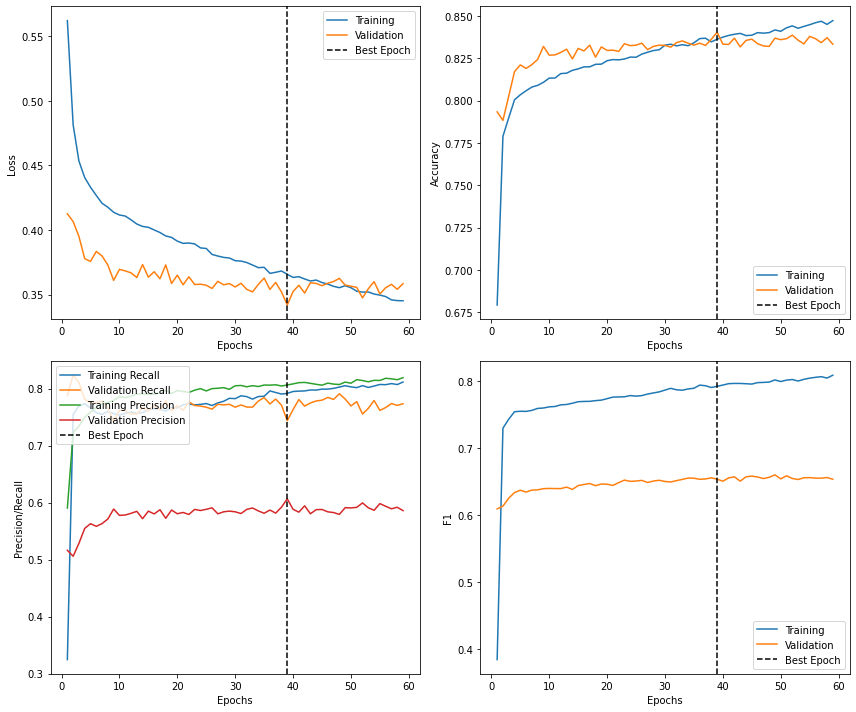

In [ ]:
try:
    x_plot = list(range(1,early_stop.best_epoch+early_stop.patience+2))
except:
    x_plot = list(range(1,n_epochs+1))
plot_history(history, x_plot)

In [ ]:
print('Classification Report')
predictions = model.predict(Xtest)
y_classes = (predictions > 0.5).astype(np.int8)
print(classification_report(ytest,y_classes))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes)
print(cm)
print('*****************************')
AUC_m3 = roc_auc_score(ytest, y_classes)
print('AUC: {}'.format(AUC_m3))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      5913
           1       0.61      0.75      0.68      1620

    accuracy                           0.84      7533
   macro avg       0.77      0.81      0.79      7533
weighted avg       0.86      0.84      0.85      7533

*****************************
Confusion Matrix
[[5143  770]
 [ 398 1222]]
*****************************
AUC: 0.8120497209538304


In [ ]:
f1_scores = []
for i in np.arange(0,1,0.01):
    y_classes_thresh = (predictions > i).astype(np.int8)
    f1_scores.append(f1_score(ytest, y_classes_thresh))
f1_scores = np.array(f1_scores)
print('Best Threshold: {}'.format(np.argmax(f1_scores)*0.01))

Best Threshold: 0.58


In [ ]:
print('Classification Report')
y_classes_best_thresh = (predictions > (np.argmax(f1_scores)*0.01)).astype(np.int8)
print(classification_report(ytest, y_classes_best_thresh))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(ytest,y_classes_best_thresh)
print(cm)
print('*****************************')
AUC_m3_threshold = roc_auc_score(ytest, y_classes_best_thresh)
print('AUC: {}'.format(AUC_m3_threshold))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5913
           1       0.66      0.70      0.68      1620

    accuracy                           0.86      7533
   macro avg       0.79      0.80      0.80      7533
weighted avg       0.86      0.86      0.86      7533

*****************************
Confusion Matrix
[[5325  588]
 [ 479 1141]]
*****************************
AUC: 0.8024395399966175


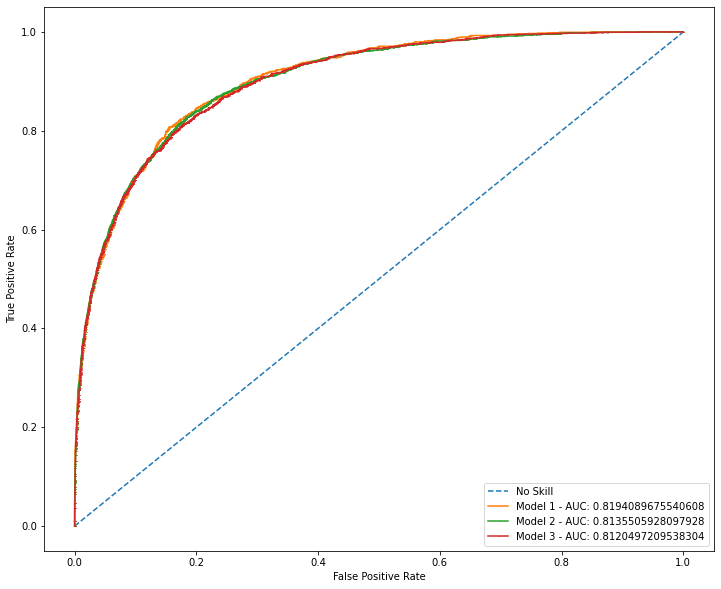

In [ ]:
fpr_m3_opt, tpr_m3_opt, thresholds_m3_opt = roc_curve(ytest, predictions)
ns_probs_m3_opt = [0 for _ in range(len(ytest))]
fpr2_m3_opt, tpr2_m3_opt, thresholds_m3_opt = roc_curve(ytest, ns_probs_m3_opt)


plt.plot(fpr2_m2_opt, tpr2_m2_opt, linestyle='--', label='No Skill')
plt.plot(fpr_m1_opt, tpr_m1_opt, marker='_',markersize=1, label='Model 1 - AUC: {}'.format(AUC_m1))
plt.plot(fpr_m2_opt, tpr_m2_opt, marker='_',markersize=1, label='Model 2 - AUC: {}'.format(AUC_m2))
plt.plot(fpr_m3_opt, tpr_m3_opt, marker='_',markersize=1, label='Model 3 - AUC: {}'.format(AUC_m3))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

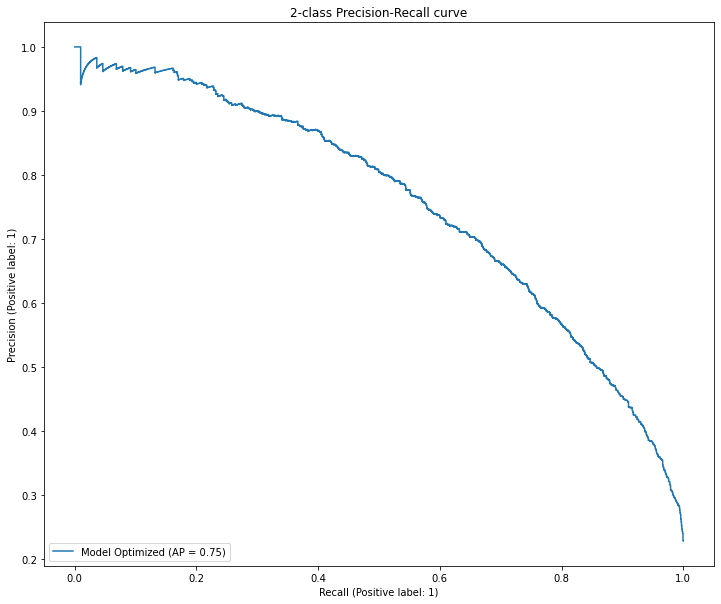

In [ ]:
display_m3_opt = PrecisionRecallDisplay.from_predictions(ytest, predictions, name="Model Optimized")
_ = display_m3_opt.ax_.set_title("2-class Precision-Recall curve")